In [43]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, cross_validation, neighbors, metrics, svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

songs_dataset = pd.read_json('MasterSongList.json')

In [2]:
songs_dataset.head()
songs_dataset.shape

(36733, 16)

In [3]:
songs_dataset = songs_dataset.loc[songs_dataset['lyrics_features'].str.len() != 0]

create a Dataframe that contains only moods and lyrics features

In [4]:
df_lyrics = songs_dataset[['lyrics_features','moods']].copy()
df_lyrics.loc[:,'lyrics_features'] = df_lyrics['lyrics_features'].apply(' '.join)
df_lyrics = df_lyrics.reset_index(drop=True)
df_lyrics.shape

(20931, 2)

 clean the lyrics:

In [5]:
import string
from string import punctuation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem.snowball import SnowballStemmer

translator = str.maketrans('', '', punctuation)
stemmer = SnowballStemmer('english')
def clean_words(raw_text):
    raw_text = raw_text.lower()
    raw_text = raw_text.translate(translator)
    split_words = raw_text.split()

    stemmed_word = [stemmer.stem(word) for word in split_words if word not in ENGLISH_STOP_WORDS]
    return ' '.join(stemmed_word)   

In [6]:
cleaned_lyrics = df_lyrics.loc[:,'lyrics_features'].apply(clean_words)
cleaned_lyrics.head(10)

0    oppa gangnam style gangnam style najeneun ttas...
1    late ve ve lose sleep dream thing babi ve ve p...
2    parti rock yeah woo let s parti rock hous toni...
3    alagamun lan weh wakun heya hanun gon alagamun...
4    j lo s new generat mr worldwid parti peopl flo...
5    today don t feel like do just wanna lay bed do...
6    s start heart reach fever pitch s bring dark f...
7    threw wish don t ask ll tell look fell way tra...
8    think like said felt happi die told right felt...
9    don t know turn head walk o don t need make co...
Name: lyrics_features, dtype: object

In [7]:
df_lyrics['cleaned_lyrics'] = cleaned_lyrics

Here, I create a new series that contains celebratory and sad moods

In [8]:
new_mood = []
for mood in df_lyrics['moods']:
    if 'celebratory' in mood:
        new_mood.append('celebratory')
    elif 'sad' in mood:
        new_mood.append('sad')
    else:
        new_mood.append(mood)
df_lyrics['new_mood'] = new_mood

New DataFrame that contains only 'celebratory' and 'sad' moods

In [9]:
celebratory_sad = df_lyrics.loc[(df_lyrics['new_mood'] == 'celebratory') | (df_lyrics['new_mood'] == 'sad')]
celebratory_sad

,lyrics_features,moods,cleaned_lyrics,new_mood
2,party rock yeah woo let s go party rock is in ...,"[happy, celebratory, rowdy]",parti rock yeah woo let s parti rock hous toni...,celebratory
3,alagamun lan weh wakun heya hanun gon alagamun...,"[happy, energetic, celebratory]",alagamun lan weh wakun heya hanun gon alagamun...,celebratory
9,don t know what for you re turning heads when ...,"[happy, celebratory]",don t know turn head walk o don t need make co...,celebratory
11,shine bright like a diamond shine bright like ...,"[energetic, celebratory]",shine bright like diamond shine bright like di...,celebratory
12,do you ever feel like a plastic bag drifting t...,"[happy, celebratory, campy]",feel like plastic bag drift wind want start fe...,celebratory
15,ohh ohh ohh ohh ohh oh her eyes her eyes make ...,"[happy, celebratory]",ohh ohh ohh ohh ohh oh eye eye make star look ...,celebratory
19,this one is for the boys with the boomin syste...,"[happy, celebratory]",boy boomin ac coolin come club blazin got stac...,celebratory
20,bring the action when you hear this in the clu...,"[happy, energetic, celebratory]",bring action hear club gotta turn shit gotta t...,celebratory
21,me not working hard yea right picture that wit...,"[energetic, celebratory]",work hard yea right pictur kodak better time s...,celebratory
22,i hopped off the plane at lax with my dreams i...,"[happy, celebratory]",hop plane lax dream cart welcom land fame xx g...,celebratory


## Bag of Words

convert all 'cleaned lyrics' into a bag of words representation

In [106]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
bag_of_words = count_vect.fit_transform(celebratory_sad['cleaned_lyrics'])
bag_of_words.shape

(2728, 19056)

Classification:
I'll use different classifiers and compare the results. Since the data is not balanced, I will not use ```accuracy_score``` to check the accuracy of the classifer

In [107]:
X = bag_of_words
y = celebratory_sad['new_mood']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2, random_state = 101)
names = ['K Nearest Neighbors', 'Logistic Regression','SVC','Random Forest']
classifiers = [KNeighborsClassifier(n_neighbors = 10), LogisticRegression(), SVC(), RandomForestClassifier()]
for name, clf in zip(names,classifiers):
    clf.fit(X_train,y_train)
    predictions = clf.predict(X_test)
    print(name)
    print('Confusion matrix:\n',metrics.confusion_matrix(y_test, predictions))
    print('Classification report:\n',metrics.classification_report(list(y_test),list(predictions)))
    print('\n'+'\n')

K Nearest Neighbors
Confusion matrix:
 [[ 86 209]
 [  9 242]]
Classification report:
              precision    recall  f1-score   support

celebratory       0.91      0.29      0.44       295
        sad       0.54      0.96      0.69       251

avg / total       0.74      0.60      0.56       546




Logistic Regression
Confusion matrix:
 [[225  70]
 [ 57 194]]
Classification report:
              precision    recall  f1-score   support

celebratory       0.80      0.76      0.78       295
        sad       0.73      0.77      0.75       251

avg / total       0.77      0.77      0.77       546




SVC
Confusion matrix:
 [[162 133]
 [ 16 235]]
Classification report:
              precision    recall  f1-score   support

celebratory       0.91      0.55      0.68       295
        sad       0.64      0.94      0.76       251

avg / total       0.79      0.73      0.72       546




Random Forest
Confusion matrix:
 [[252  43]
 [ 91 160]]
Classification report:
              precision  

From here, SVC yields the highest precision. I'll apply the same stuffs for TF-IDF

## TF - IDF

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer()
tf_idf = tf_idf_vect.fit_transform(celebratory_sad['cleaned_lyrics'])
tf_idf.shape

(2728, 19056)

In [110]:
X = tf_idf
y = celebratory_sad['new_mood']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2, random_state = 42)
names = ['K Nearest Neighbors', 'Logistic Regression','SVC','Random Forest']
classifiers = [KNeighborsClassifier(n_neighbors = 10), LogisticRegression(), SVC(), RandomForestClassifier()]
for name, clf in zip(names,classifiers):
    clf.fit(X_train,y_train)
    predictions = clf.predict(X_test)
    print(name)
    print('Confusion matrix:\n',metrics.confusion_matrix(y_test, predictions))
    print('Classification report:\n',metrics.classification_report(list(y_test),list(predictions)))
    print('\n'+'\n')

K Nearest Neighbors
Confusion matrix:
 [[252  49]
 [121 124]]
Classification report:
              precision    recall  f1-score   support

celebratory       0.68      0.84      0.75       301
        sad       0.72      0.51      0.59       245

avg / total       0.69      0.69      0.68       546




Logistic Regression
Confusion matrix:
 [[222  79]
 [ 57 188]]
Classification report:
              precision    recall  f1-score   support

celebratory       0.80      0.74      0.77       301
        sad       0.70      0.77      0.73       245

avg / total       0.75      0.75      0.75       546




SVC
Confusion matrix:
 [[301   0]
 [245   0]]
Classification report:
              precision    recall  f1-score   support

celebratory       0.55      1.00      0.71       301
        sad       0.00      0.00      0.00       245

avg / total       0.30      0.55      0.39       546






/home/antran96/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Random Forest
Confusion matrix:
 [[232  69]
 [ 91 154]]
Classification report:
              precision    recall  f1-score   support

celebratory       0.72      0.77      0.74       301
        sad       0.69      0.63      0.66       245

avg / total       0.71      0.71      0.71       546






The result is very different for each of the classifier I used for bag_of_words. SVC yields the lowest precision while Logistic Regession has the highest score. I was a little confused since all of the scores for 'sad' in SVC was 0. Not sure why...

## Doc2Vec


In [13]:
from gensim.models.doc2vec import Doc2Vec

Now I'll create 4 files: train-celebratory.txt, test-celebratory.txt, train-sad.txt, test-sad.txt,

In [112]:
from sklearn.utils import shuffle

def create_train_test(file,X,y):
    shuffle(file) #randomize the data
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.5, random_state = 42)
    return X_train, X_test

#train-celebratory.txt, test-celebratory.txt
y1 = celebratory_sad.loc[(celebratory_sad['new_mood'] == 'celebratory'),'new_mood']
X1 = celebratory_sad.loc[(celebratory_sad['new_mood'] == 'celebratory'),'lyrics_features']
X_train1, X_test1 = create_train_test(df_lyrics,X1,y1)    
X_train1.to_csv('train-celebratory.txt', sep='\n', index=False)
X_test1.to_csv('test-celebratory.txt', sep='\n', index=False)

#train-sad.txt, test-sad.txt
y2 = celebratory_sad.loc[(celebratory_sad['new_mood'] == 'sad'),'new_mood']
X2 = celebratory_sad.loc[(celebratory_sad['new_mood'] == 'sad'),'lyrics_features']
X_train2, X_test2 = create_train_test(df_lyrics,X2,y2)    
X_train2.to_csv('train-sad.txt', sep='\n', index=False)
X_test2.to_csv('test-sad.txt', sep='\n', index=False)


In [15]:
print(X_train1.count(), X_train2.count(), X_test1.count(), X_test2.count())

739 624 740 625


In [16]:
%run Doc2VecHelperFunctions.ipynb

read the documents using TaggedLineDocument

In [17]:
sources = {'test-celebratory.txt':'TEST_CELEBRATORY', 'test-sad.txt':'TEST_SAD', 'train-celebratory.txt':'TRAIN_CELEBRATORY', 'train-pos.txt':'TRAIN_SAD'}
sentences = TaggedLineDocument(sources)

build and train the model

In [18]:
model = Doc2Vec(model_min_count=1, model_window=10, model_vector_size=100, model_sample=1e-4, model_negative=5, model_workers=7)

model.build_vocab(sentences.to_array())


In [19]:
model_epoch_range=10
for epoch in range(model_epoch_range):
    model.train(sentences.sentences_perm(), total_examples=model.corpus_count, epochs=model.epochs)


In [20]:
model.save('./song_lyrics.d2v')

In [21]:
model = Doc2Vec.load('./song_lyrics.d2v')

In [22]:
model.wv.most_similar('good')

[('great', 0.6851962804794312),
 ('fine', 0.6468544602394104),
 ('decent', 0.6341749429702759),
 ('cool', 0.6161535978317261),
 ('bad', 0.6024141907691956),
 ('nice', 0.5952433347702026),
 ('terrific', 0.57065749168396),
 ('funny', 0.5624045133590698),
 ('strong', 0.5556851625442505),
 ('wonderful', 0.5504271984100342)]

In [25]:
model['TRAIN_CELEBRATORY_0']
print(model['TRAIN_CELEBRATORY_0'].shape)

(100,)


## Classifying Sentiments

### Training Vectors

train_celebratory, train_sad, test_celebratory, test_sad= 739, 624, 740, 625



In [28]:
train_arrays = np.zeros((1363, 100))
train_labels = np.zeros(1363)

for i in range(739):
    prefix_train_celebratory = 'TRAIN_CELEBRATORY_' + str(i)
    train_arrays[i] = model[prefix_train_celebratory]
    train_labels[i] = 1

for i in range(624):
    prefix_train_sad = 'TRAIN_SAD_' + str(i)
    train_arrays[739 + i] = model[prefix_train_sad]
    train_labels[739 + i] = 0

## Testing Vectors

In [30]:
test_arrays = np.zeros((1365, 100))
test_labels = np.zeros(1365)

for i in range(740):
    prefix_test_celebratory = 'TEST_CELEBRATORY_' + str(i)
    test_arrays[i] = model[prefix_test_celebratory]
    test_labels[i] = 1

for i in range(625):
    prefix_test_sad = 'TEST_SAD_' + str(i)
    test_arrays[740 + i] = model[prefix_test_sad]
    test_labels[740 + i] = 0

In [113]:
names = ['K Nearest Neighbors', 'Logistic Regression','SVC','Random Forest','Random Forest(balanced)']
classifiers = [KNeighborsClassifier(n_neighbors = 10), LogisticRegression(), SVC(), RandomForestClassifier(),RandomForestClassifier(class_weight='balanced')]
for name, clf in zip(names,classifiers):
    clf.fit(train_arrays,train_labels)
    predictions = clf.predict(test_arrays)
    print(name)
    print('Confusion matrix:\n',metrics.confusion_matrix(test_labels, predictions))
    print('Classification report:\n',metrics.classification_report(list(test_labels),list(predictions)))
    print('\n\n')

K Nearest Neighbors
Confusion matrix:
 [[ 79 546]
 [ 32 708]]
Classification report:
              precision    recall  f1-score   support

        0.0       0.71      0.13      0.21       625
        1.0       0.56      0.96      0.71       740

avg / total       0.63      0.58      0.48      1365




Logistic Regression
Confusion matrix:
 [[ 15 610]
 [ 13 727]]
Classification report:
              precision    recall  f1-score   support

        0.0       0.54      0.02      0.05       625
        1.0       0.54      0.98      0.70       740

avg / total       0.54      0.54      0.40      1365




SVC
Confusion matrix:
 [[ 23 602]
 [  9 731]]
Classification report:
              precision    recall  f1-score   support

        0.0       0.72      0.04      0.07       625
        1.0       0.55      0.99      0.71       740

avg / total       0.63      0.55      0.41      1365




Random Forest
Confusion matrix:
 [[118 507]
 [ 38 702]]
Classification report:
              precision  

Random Forest yields the highest precision in Doc2Vec, slightly higher than when I set class_weight to balanced. So for 3 methods, Bag of Words yields the highest precision

## K Mean Clustering plots

bag_of_words


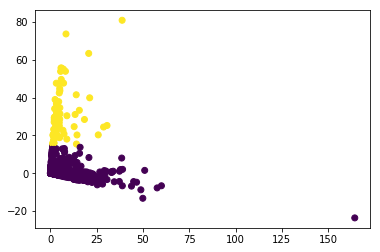

tf_idf


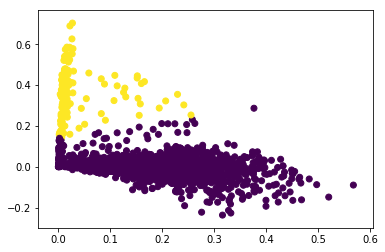

In [122]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD


svd = TruncatedSVD(n_components=2)
kmeans = KMeans(n_clusters = 2, random_state = 0)
methods = [bag_of_words, tf_idf]
names = ['bag_of_words', 'tf_idf']
for name,method in zip(names,methods):
    X_2d = svd.fit_transform(method)
    X_clustered = kmeans.fit_predict(X_2d)
    print(name)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=X_clustered)
    plt.show()
    

Not sure if I get this right but the scales for bag_of_words and tf_idf are different. And I couldn't determine the right legend for each plot (yellow/purple -> sad/celebratory???)